Source: https://www.kaggle.com/kmader/parkinsons-drawings
Orignial data from: Zham P, Kumar DK, Dabnichki P, Poosapadi Arjunan S and Raghav S (2017) Distinguishing Different Stages of Parkinson’s Disease Using Composite Index of Speed and Pen-Pressure of Sketching a Spiral. Front. Neurol. 8:435. doi: 10.3389/fneur.2017.00435

As suggested by the author of the Kernal who I forked from, Kevin Mader, there are a couple of interesting analyses that could be performed on this dataset:

1. Try and order the curves and get realistic (if possibly inaccurate) trajectories for the pen movement
2. Quantify the pressure by looking at the thickness of the skeleton at specific points.
3. Start to quantify the 'jigglyness' of the motion (fourier analysis of the time series?, differential motion?)

Looking at the curves, this is an interesting image processing problem.

TODO: Map trajectory of path, indexed labelled x, y positions for potential first to last pen movement. A* or other. Dilation grow but restricted to segmented path?
Use this to then correlate jitteryness after plotting index vs x, y . Or measure difference in distance from prvious data points.
Can we build a feature set to be used for classification. Compare with DL classifier. Advnatge we also get understanding from random forest classifier with feature engineering. 

In [1]:
# PLOTTING STYLE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
#plt.rcParams['axes.labelcolor'] = 'white'
plt.style.use('ggplot')
%matplotlib notebook

In [2]:
import numpy as np
from skimage.io import imread
from skimage.util import montage as montage2d
import pandas as pd
from pathlib import Path
data_dir = Path(r'D:\Docs\Python_code\ParkinsonsSketch\178338_401677_bundle_archive\drawings')

# Organize Data
We will store our data in a pandas dataframe. We can also categorize the data based on the directory path name. The files are organized such that we have {spiral-wave\train-test\healthy-parkinson}. As you can see we can therefor organize by the type of drawing, training or testing for later classification, and the class label for the prediction.

In [3]:
draw_df = pd.DataFrame({'path': list(data_dir.glob('*/*/*/*.png'))})
draw_df['img_id'] = draw_df['path'].map(lambda x: x.stem)
draw_df['disease'] = draw_df['path'].map(lambda x: x.parent.stem)
draw_df['validation'] = draw_df['path'].map(lambda x: x.parent.parent.stem)
draw_df['activity'] = draw_df['path'].map(lambda x: x.parent.parent.parent.stem)
print(draw_df.shape, 'images loaded')
draw_df.sample(3)

(204, 5) images loaded


,path,img_id,disease,validation,activity
126,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V08PO01,parkinson,testing,wave
3,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V04HE01,healthy,testing,spiral
173,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V03PO03,parkinson,training,wave


# Display Images
Apply some preprocessing

In [4]:
def process_imread(in_path, resize=True):
    """read images, invert and scale them"""
    c_img = 1.0-imread(in_path, as_gray=True)
    max_dim = np.max(c_img.shape)
    if not resize:
        return c_img
    if c_img.shape==(256, 256):
        return c_img
    if max_dim>256:
        big_dim = 512
    else:
        big_dim = 256
    """ pad with zeros and center image, sizing to either 256 or 512"""   
    out_img = np.zeros((big_dim, big_dim), dtype='float32')
    c_offset = (big_dim-c_img.shape[0])//2
    d_offset = c_img.shape[0]+c_offset
    
    e_offset = (big_dim-c_img.shape[1])//2
    f_offset = c_img.shape[1]+e_offset
    out_img[c_offset:d_offset, e_offset:f_offset] = c_img[:(d_offset-c_offset), :(f_offset-e_offset)]
    return out_img

![example resizing](images/img_resize.png)

Next, we create a mosaic or montage of plots to show images. We group the images by their activity ie spiral or wave and if the drawer suffered from parkinsons or not. We take the first 9 images per montage image.

<IPython.core.display.Javascript object>


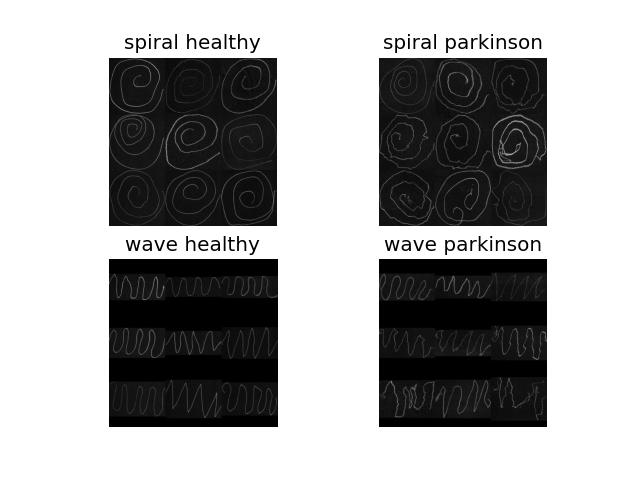

In [5]:
fig, m_axs = plt.subplots(2, 2)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([process_imread(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

# Filter and Segment
We can do some preprocessing to get just the drawn path

In [6]:
from skimage.filters import threshold_yen as thresh_func
from skimage.filters import median
from skimage.morphology import disk, opening, diamond

def read_and_thresh(in_path, resize=True):
    c_img = process_imread(in_path, resize=resize)
    c_img = (255*c_img).clip(0, 255).astype('uint8')
    c_img = median(c_img, disk(1))
    c_thresh = thresh_func(c_img)
    return c_img>c_thresh

In [7]:
disk(1)

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

<IPython.core.display.Javascript object>


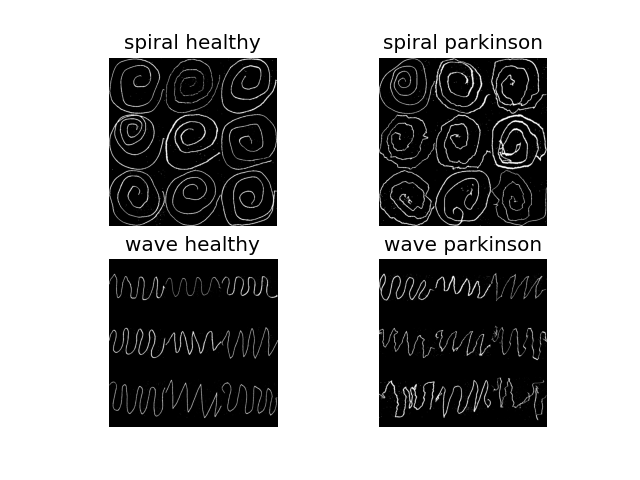

In [8]:
fig, m_axs = plt.subplots(2, 2)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([read_and_thresh(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

In [9]:
%%time
# run all images, don't resize if not going to plot in montage
draw_df['thresh_img'] = draw_df['path'].map(lambda x: read_and_thresh(x, resize=False))

Wall time: 3.76 s


<IPython.core.display.Javascript object>


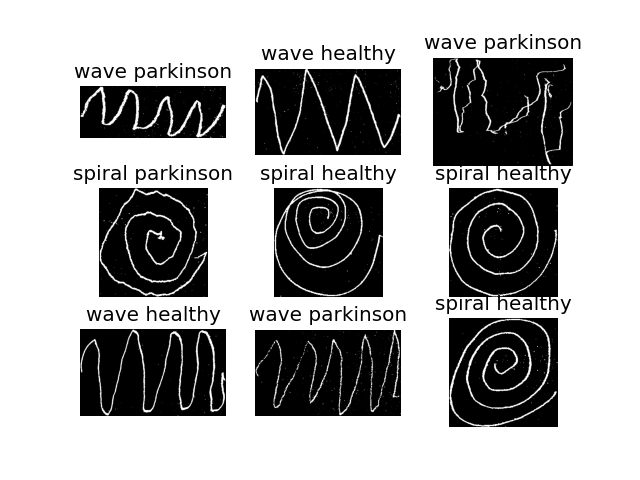

In [10]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    c_ax.imshow(c_row['thresh_img'], cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

# Clean
Keep only large enough components that are >1% of activated pixels; defined by cutoff. First label each separate object in image and sum the areas for each label identified (that isn't 0). Keep the index if the count is more than 1% of the total. Perform negative sort to have the largest objects with label 1. Replace the old label number with the new ordered id.

In [11]:
from skimage.morphology import label
from skimage.morphology import closing
def label_sort(in_img, cutoff=0.01):
    total_cnt = np.sum(in_img>0)
    lab_img = label(in_img)
    new_image = np.zeros_like(lab_img)
    remap_index = []
    for k in np.unique(lab_img[lab_img>0]):
        cnt = np.sum(lab_img==k) # get area of labelled object
        if cnt>total_cnt*cutoff:
            remap_index+=[(k, cnt)]
    sorted_index = sorted(remap_index, key=lambda x: -x[1]) # reverse sort - largest is first
    for new_idx, (old_idx, idx_count) in enumerate(sorted_index, 1): #enumerate starting at id 1
        new_image[lab_img==old_idx] = new_idx
    return new_image

<IPython.core.display.Javascript object>


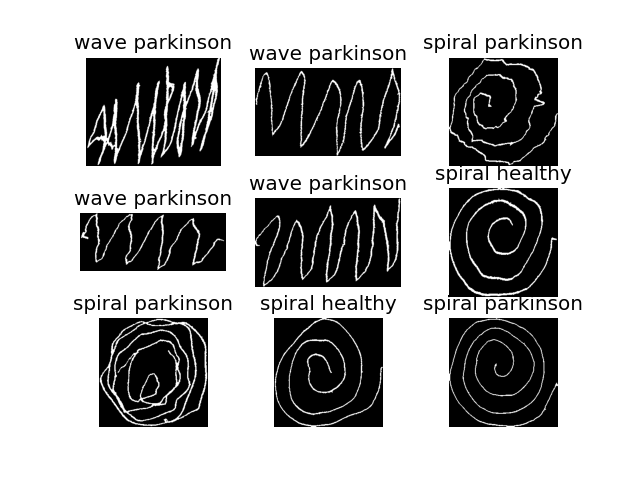

In [12]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9, random_state = 1).iterrows()):
    clean_img = closing(label_sort(c_row['thresh_img'])>0, disk(1))
    c_ax.imshow(clean_img, cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

In [13]:
%%time
draw_df['clean_img'] = draw_df['thresh_img'].map(lambda x: closing(label_sort(x)>0, disk(1)))

Wall time: 6.56 s


<IPython.core.display.Javascript object>


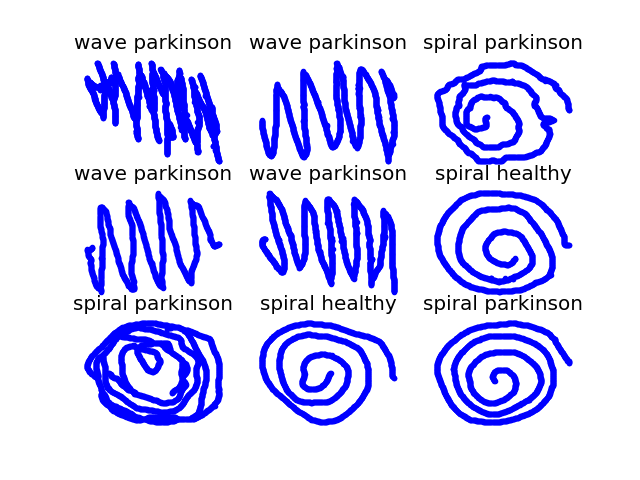

In [14]:
from skimage.morphology import skeletonize

fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9, random_state = 1).iterrows()):
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    
    c_ax.plot(skel_x, skel_y, 'b.')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

# Convert to table
Convert all the skeletonized plots to a dataframe where each row is a single data point for each image pixel.  

In [15]:
all_row_list = []
for _, c_row in draw_df.iterrows():
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    for x, y in zip(skel_x, skel_y):
        d_row = dict(**{k: v for k,v in c_row.items() if len(np.shape(v))<1})
        d_row['x'] = x
        d_row['y'] = y
        all_row_list += [d_row]

In [17]:
all_row_df = pd.DataFrame(all_row_list)
all_row_df.sample(3)

,path,img_id,disease,validation,activity,x,y
178636,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V55HO11,healthy,testing,wave,0.148438,0.727273
182225,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V02PO01,parkinson,testing,wave,0.597656,0.804762
64966,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V08HE02,healthy,training,spiral,0.687500,0.164062


# Show all drawings on same plot
By plotting the skeleton pixels as points and rescaling we can overlay all of the images on top of each other for better visualization. The healthy patients are significantly more consistent than the Parkinson's.

<IPython.core.display.Javascript object>


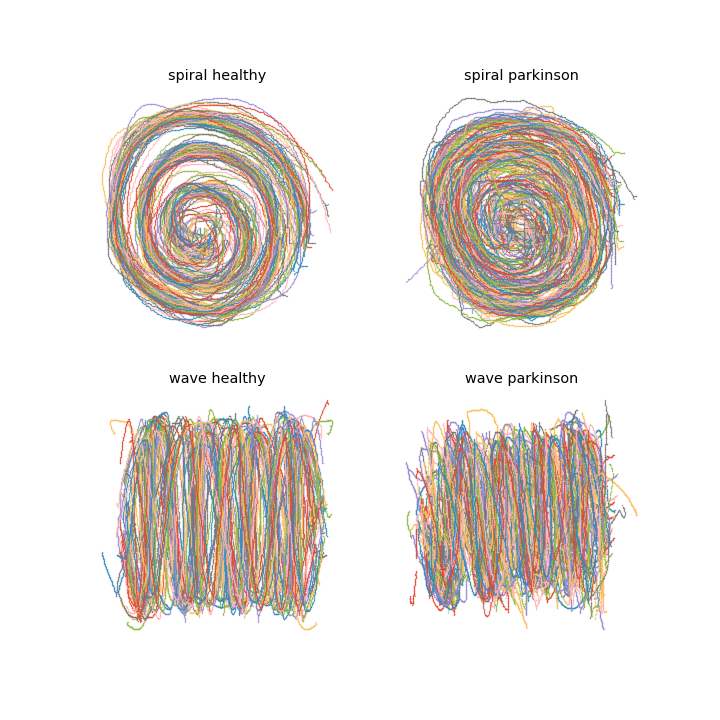

In [18]:
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10), dpi=72)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), all_row_df.groupby(['activity', 'disease'])):
    for c_id, d_rows in c_rows.groupby('img_id'):
        mean_std = np.mean([d_rows['x'].std(), d_rows['y'].std()])
        c_ax.plot((d_rows['x']-d_rows['x'].mean())/mean_std, 
                  (d_rows['y']-d_rows['y'].mean())/mean_std, '.', label=c_id, ms=0.75)
    #c_ax.legend()
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

# Pen thickness quantification
Distance map and skeleton ridge + std to account for any inconsistent pen thickness from varying pressure applied.

In [19]:
from skimage.morphology import medial_axis
from skimage.morphology import skeletonize

In [20]:
def stroke_thickness_img(in_img):
    skel, distance = medial_axis(in_img, return_distance=True)
    skeleton = skeletonize(in_img)
    # Distance to the background for pixels of the skeleton
    return distance * skeleton

<IPython.core.display.Javascript object>


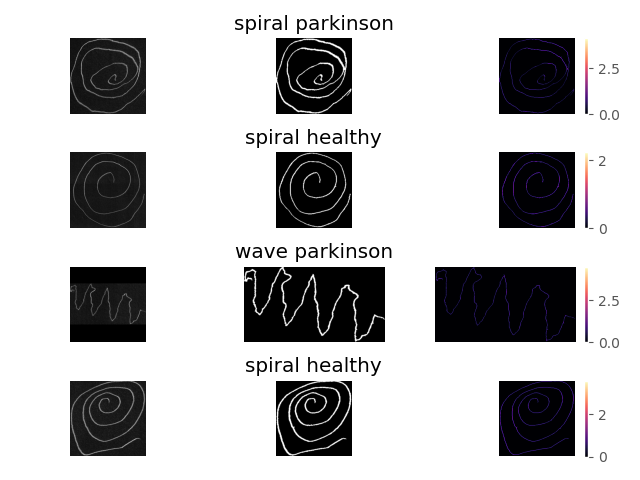

In [21]:
i = 0
fig, m_axs = plt.subplots(4, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(4, random_state = 2).iterrows()):

    dist_img = stroke_thickness_img(c_row['clean_img'])
    
    cset1 = m_axs[i,2].imshow(dist_img, cmap='magma')
    fig.colorbar(cset1, ax=m_axs[i,2])
    m_axs[i,2].axis('off')
    
    cset2 = m_axs[i,1].imshow(c_row['clean_img'],cmap='gray')
    m_axs[i,1].set_title('{activity} {disease}'.format(**c_row))
    m_axs[i,1].axis('off')
    
    cset3 = m_axs[i,0].imshow(process_imread(c_row['path']),cmap='gray')
    m_axs[i,0].axis('off')
    
    i += 1
    fig.tight_layout()

Edit slightly to return only values which are above 0 and store

In [22]:
def stroke_thickness(in_img):
    skel, distance = medial_axis(in_img, return_distance=True)
    skeleton = skeletonize(in_img)
    # Distance to the background for pixels of the skeleton
    dist = distance * skeleton
    return dist[dist>0]

In [23]:
%%time
draw_df['thickness'] = draw_df['clean_img'].map(lambda x: stroke_thickness(x))

Wall time: 18 s


In [24]:
draw_df['mean_thickness'] = draw_df['thickness'].apply(np.mean)
draw_df['std_thickness'] = draw_df['thickness'].apply(np.std)

In [25]:
draw_df.groupby(['activity', 'disease'])['mean_thickness'].mean()

activity  disease  
spiral    healthy      1.894230
          parkinson    1.879122
wave      healthy      2.559639
          parkinson    2.819350
Name: mean_thickness, dtype: float64

In [26]:
draw_df.groupby(['activity', 'disease'])['std_thickness'].mean()

activity  disease  
spiral    healthy      0.428052
          parkinson    0.524317
wave      healthy      0.518404
          parkinson    0.709551
Name: std_thickness, dtype: float64

<IPython.core.display.Javascript object>


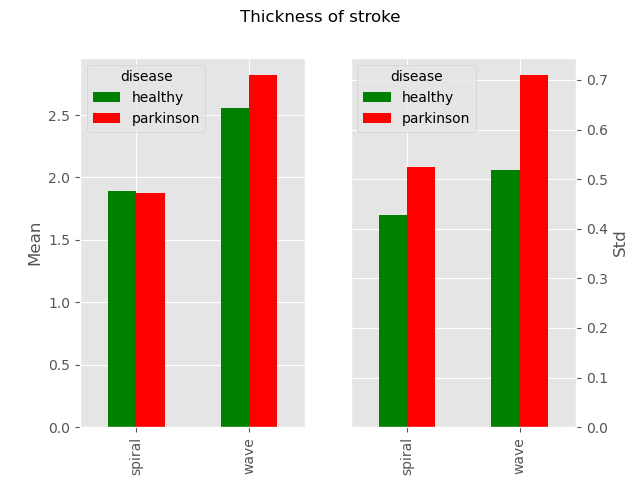

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2)
plt.suptitle('Thickness of stroke')
draw_df.groupby(['activity','disease'])['mean_thickness'].mean().unstack().plot(kind='bar', legend=True, 
                                                                                color=['g', 'r'], ax = ax[0])
ax[0].set_ylabel("Mean")
draw_df.groupby(['activity','disease'])['std_thickness'].mean().unstack().plot(kind='bar', legend=True, 
                                                                               color=['g', 'r'], ax = ax[1])
ax[1].set_ylabel("Std")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()

Interestingly enough we can see that on average the thickness is greater for Parkinsons patients but more so the variation in the thickness, indicating the inconsistent hand movements so often associated with the disease. Both these results are however impacted by some drawings that overlap the spiral or wave lines, and therefore increasing the 'thickness'.The jittery-ness will also increase the apparent thickness of the stroke. Looking at the examples above I think you will see what I mean, so it is not just pen pressure that is being captured but a combination of pen pressure, as well as inconsistency with the drawing movement. 

# Pen movement trajectories
We can try and determine the creation of each drawing in time by labelling each pixel with an order number. As you can see from some of the examples above, this can be a little tricky (and not perfectly accurate) as there isn't a clear starting/ end point and pen trajectory - but we will try a algorithm and have it be consistent taking into account some of these difficulties. 
Can start by first creating a single pen path - for simplicity we will remove branches and other broken paths. We can define start and end points and connect these 'in time'. 

![example check of endpoints](images/endpoints.jpg)

## Finding end-points

In [109]:
from scipy import ndimage
from skimage import filters

In [130]:
k_nn = np.array([[1,1,1],[1,0,1],[1,1,1]])
k_cross = np.array([[0,1,0],[1,0,1],[0,1,0]])

Test on one image

In [111]:
c_id = 'V07PO02'#'V07PE03' #'V10PO03'
# a = np.where(spiral_draw_df.iloc[2]['skel_img'] == True, 1, 0)
# img_path = draw_df.loc[draw_df['img_id'] == c_id]['path']
# img = process_imread(img_path.values[0])
img = np.where(draw_df.loc[draw_df['img_id'] == c_id]['clean_img'].values[0] == True, 1, 0).astype(np.uint8)

In [112]:
def skeleton_drawing(in_img, k):
    edge_img = skeletonize(in_img, method='lee')
    return (edge_img > 0).astype(np.uint8)

In [113]:
img_skel = skeleton_drawing(img, k_nn)

<IPython.core.display.Javascript object>


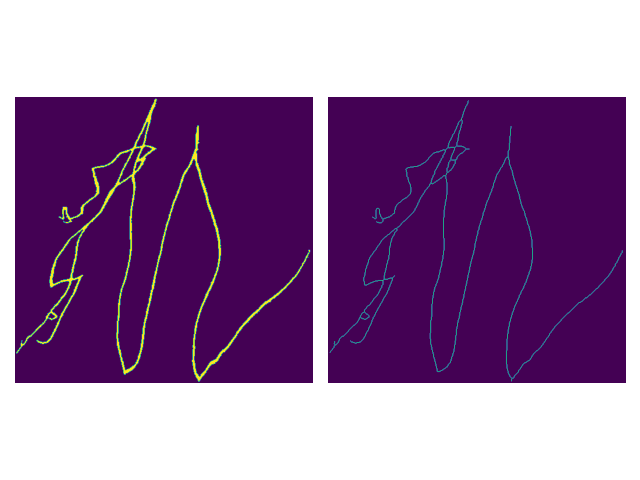

In [114]:
fig, m_axs = plt.subplots(1,2)
m_axs[0].imshow(img)
m_axs[0].axis('off')
m_axs[1].imshow(img_skel)
m_axs[1].axis('off')
plt.show()
fig.tight_layout()

In [115]:
def nearest_neighbours(in_img, k):
    a = np.where(in_img == True, 1, 0)
    a_nn = ndimage.convolve(a, k, mode='constant', cval=0.0)
    return (a_nn * a).astype(np.uint8)

In [116]:
# nearest neighbours
img_nn = nearest_neighbours(img_skel, k_nn)

In [117]:
# edge points - only 1 neighbour
img_ep = (img_nn == 1).astype(np.uint8)

In [118]:
np.sum(img_ep[img_ep != 0])

11

Create edges by removing intersection locations

In [119]:
def create_branches(in_img, k_nn):
    # input: skeleton image 0, 1
    a = np.where(in_img != 0, 1, 0)
    a_nn = nearest_neighbours(in_img, k_nn)
    intersections = np.where(a_nn >= 3, 1, 0)
    a_no_branches = np.where(intersections, 0, 1) * a # mask at intersections
    a_keep = label(a_no_branches) # remove branches
    return a_keep#((a_keep + intersections) > 0).astype(np.uint8)

In [120]:
branch_label_img = create_branches(img_skel, k_nn)

<IPython.core.display.Javascript object>


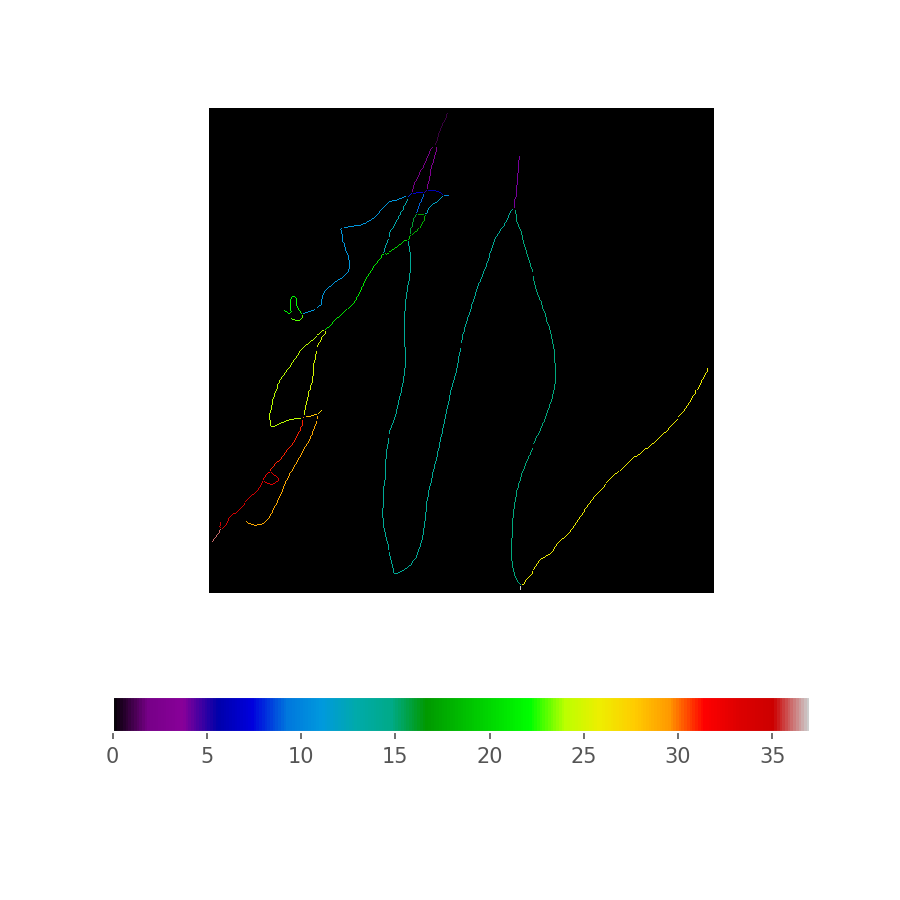

In [121]:
fig, m_axs = plt.subplots(1,1, figsize=(6,6), dpi=150)
im = m_axs.imshow(branch_label_img, cmap='nipy_spectral', interpolation='none')
m_axs.axis('off')
fig.colorbar(im, ax=m_axs, orientation='horizontal')
plt.show()

<IPython.core.display.Javascript object>


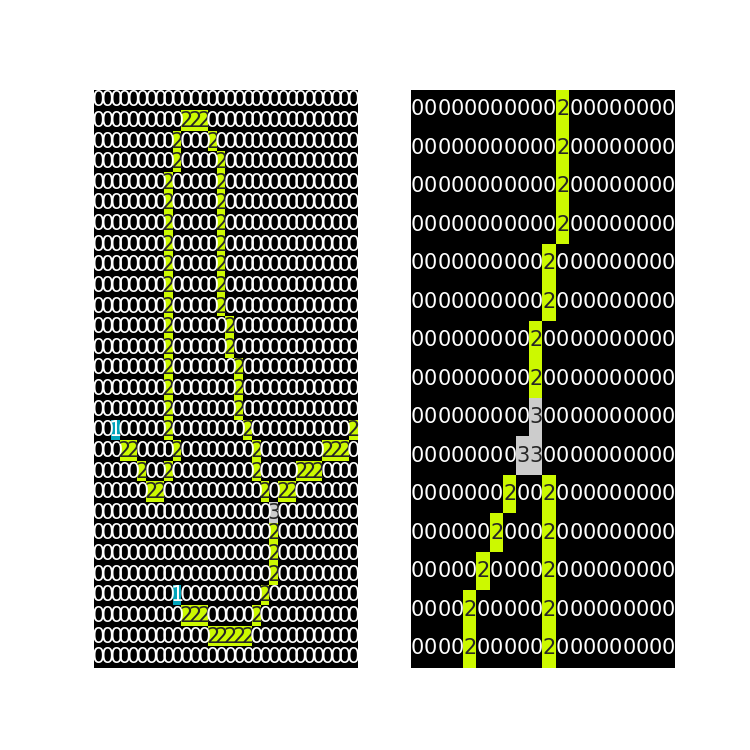

In [122]:
fig, m_axs = plt.subplots(1, 2, figsize = (5,5), dpi=150)
sns.heatmap(img_nn[190:218, 74:104], annot=True, ax=m_axs[0], 
            fmt="d", cmap='nipy_spectral', cbar=False)
sns.heatmap(img_nn[30:45, 220:240], annot=True, ax=m_axs[1], 
            fmt="d", cmap='nipy_spectral', cbar=False)
m_axs[0].axis('off')
m_axs[1].axis('off')
plt.show()

Two examples of intersections and end points. In the right one, this will give issues when defining nodes. We need only single 3 connection point. 

Sum of these intersections is greater than the correct intersection. We can sum NN image and threshold to isolate these. We can then apply morphological operaion to isolate to single pixel.
## from original NN, get intersection n>= 3 and perform labelling of edges as normal. 
## Get cleaned nodes. 
## Use original nodes and assign node value of edge. Should result with labelled edges.
## Overwrite with corrected nodes.

In [124]:
def sum_nearest_neighbours(in_img, k):
    a = np.where(in_img > 0, 1, 0)
    a_nn = ndimage.convolve(in_img, k, mode='constant', cval=0.0)
    return (a_nn * a).astype(np.uint8)

Get problem locations by using sum NN - use k_nn

In [125]:
def get_edges(labelled_img, nodes):
    z_nn = labelled_img
    edges = []
    for x,y in nodes:
#         nn = np.asarray([z_nn[x-1, y+1],z_nn[x+0, y+1],z_nn[x+1, y+1],
#                          z_nn[x-1, y+0],z_nn[x+0, y+0],z_nn[x+1, y+0],
#                          z_nn[x-1, y-1],z_nn[x+0, y-1],z_nn[x+1, y-1]])
        nn = np.asarray([z_nn[x-1, y+1],z_nn[x+0, y+1],z_nn[x+1, y+1],
                         z_nn[x-1, y+0],z_nn[x+1, y+0],
                         z_nn[x-1, y-1],z_nn[x+0, y-1],z_nn[x+1, y-1]])
        edges.append(nn[nn != 0])

    return edges

In [126]:
def clean_labelled(in_img, label_img):
    
    k_nn = np.array([[1,1,1],[1,0,1],[1,1,1]])
    k_cross = np.array([[0,1,0],[1,0,1],[0,1,0]])
    
    img_2_conn_sum = sum_nearest_neighbours(in_img, k_nn)
    img_1_conn_sum = sum_nearest_neighbours(in_img, k_cross)
    
    tmp_nodes = np.where(img_2_conn_sum >= 8)    
    tmp_nodes = list(zip(*tmp_nodes))
    tmp_edges = get_edges(label_img, tmp_nodes)
    edges_around_nodes = get_edges(label_img, tmp_nodes)
    for i, (x,y) in enumerate(test_nodes):
        label_img[x,y] = tmp_edges[i]
    
    tmp_nn = (img_1_conn_sum>=3)*(img_1_conn_sum<=5) #incorrect intersections
    img_cleaned_nn = np.where(tmp_nn==True, 2, in_img) # reset to 'corrected' NN to value of 2
    return img_cleaned_nn, label_img

In [127]:
img_cleaned_nn, img_cleaned_label = clean_labelled(img_nn, branch_label_img)

<IPython.core.display.Javascript object>


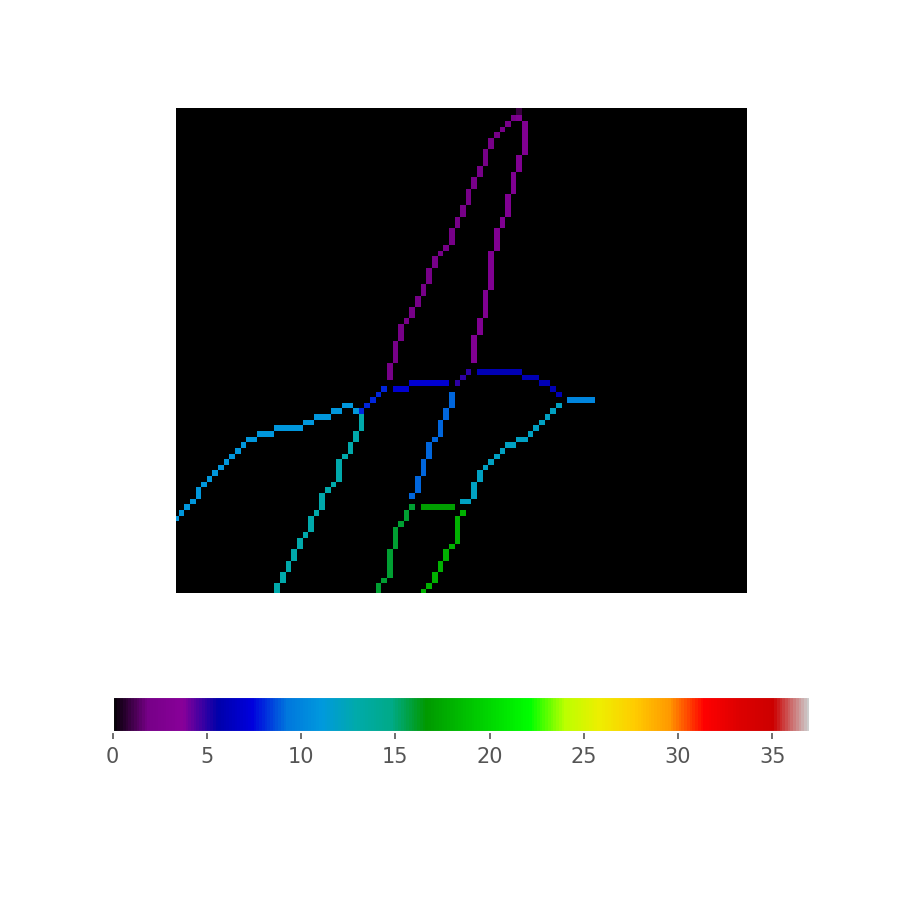

In [128]:
fig, m_axs = plt.subplots(1,1, figsize=(6,6), dpi=150)
im = m_axs.imshow(img_cleaned_label, cmap='nipy_spectral', interpolation='none')
m_axs.axis('off')
fig.colorbar(im, ax=m_axs, orientation='horizontal')
plt.show()

<IPython.core.display.Javascript object>


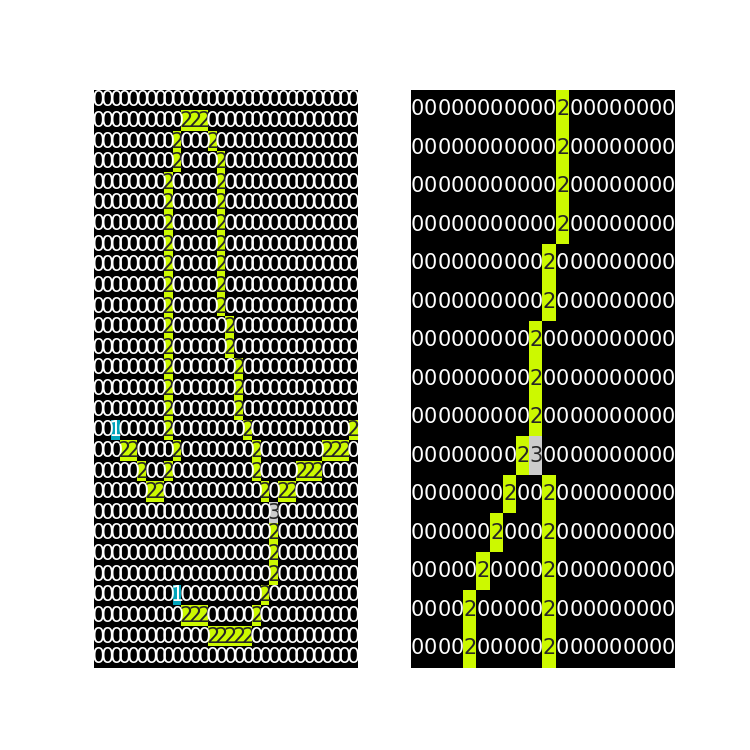

In [129]:
fig, m_axs = plt.subplots(1, 2, figsize = (5,5), dpi=150)
sns.heatmap(img_cleaned_nn[190:218, 74:104], annot=True, ax=m_axs[0], 
            fmt="d", cmap='nipy_spectral', cbar=False)
sns.heatmap(img_cleaned_nn[30:45, 220:240], annot=True, ax=m_axs[1], 
            fmt="d", cmap='nipy_spectral', cbar=False)
m_axs[0].axis('off')
m_axs[1].axis('off')
plt.show()

Get nodes (intersection) locations

In [131]:
nodes_3 = np.where(img_cleaned_nn == 3) # nodes position
nodes_3 = list(zip(*nodes_3))
nodes_1 = np.where(img_cleaned_nn == 1) # nodes position
nodes_1 = list(zip(*nodes_1))
all_nodes = nodes_1 + nodes_3

In [356]:
print(all_nodes)

[(6, 241), (50, 314), (89, 242), (206, 76), (214, 83), (264, 505), (307, 114), (419, 38), (420, 11), (439, 3), (488, 315), (39, 229), (83, 221), (86, 206), (87, 217), (89, 237), (91, 201), (103, 309), (107, 211), (108, 218), (129, 205), (135, 201), (148, 177), (210, 94), (226, 117), (311, 110), (313, 96), (315, 94), (369, 62), (378, 55), (426, 12), (484, 316)]


View the edges and intersection points as defined by drawing on image

In [133]:
# view edge points and later intersection points
from skimage import draw

In [134]:
# edge points
ep = np.where(img_nn == 1) # end nodes position
ep = list(zip(*ep))
# intersections
intersections = np.where(img_cleaned_nn == 3) # nodes position
intersections = list(zip(*intersections))

In [135]:
img_nn_copy = np.copy(img_cleaned_nn)

In [136]:
# add edge points to image
for x,y in ep:
    rr,cc = draw.disk((x,y),2)
    img_nn_copy[rr, cc] = 50

In [137]:
# add intersections also to image
for x,y in intersections:
    rr,cc = draw.disk((x,y),2)
    img_nn_copy[rr, cc] = 100

<IPython.core.display.Javascript object>


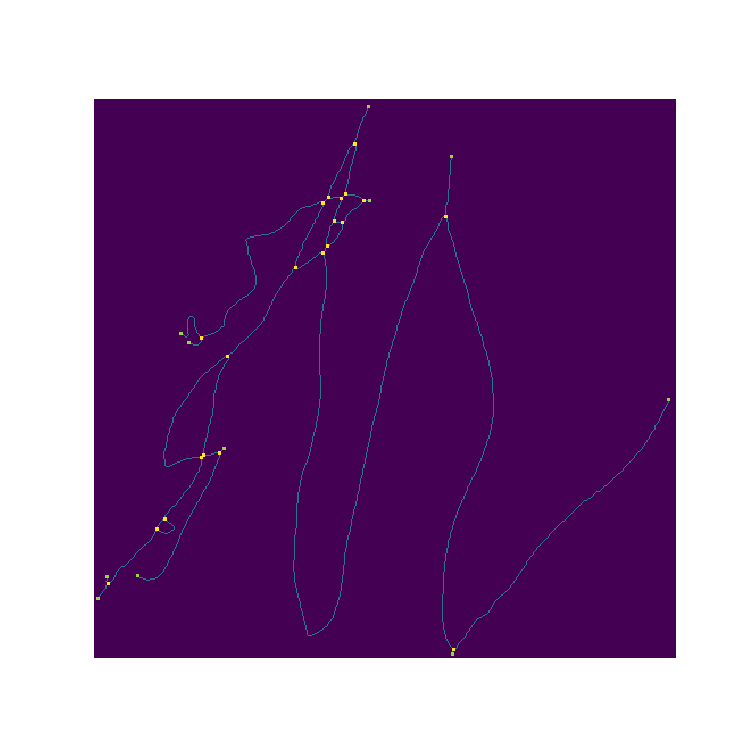

In [138]:
fig, m_axs = plt.subplots(1, 1, figsize = (5,5), dpi=150)
m_axs.imshow(img_nn_copy, interpolation='none', norm=mpl.colors.PowerNorm(gamma=0.25))
m_axs.axis('off')
plt.show()

In [139]:
img_edge_labelled_copy = np.copy(img_cleaned_label)
for x,y in ep:
    rr,cc = draw.disk((x,y),1)
    img_edge_labelled_copy[rr, cc] = 50
for x,y in intersections:
    rr,cc = draw.disk((x,y),1)
    img_edge_labelled_copy[rr, cc] = 100

<IPython.core.display.Javascript object>


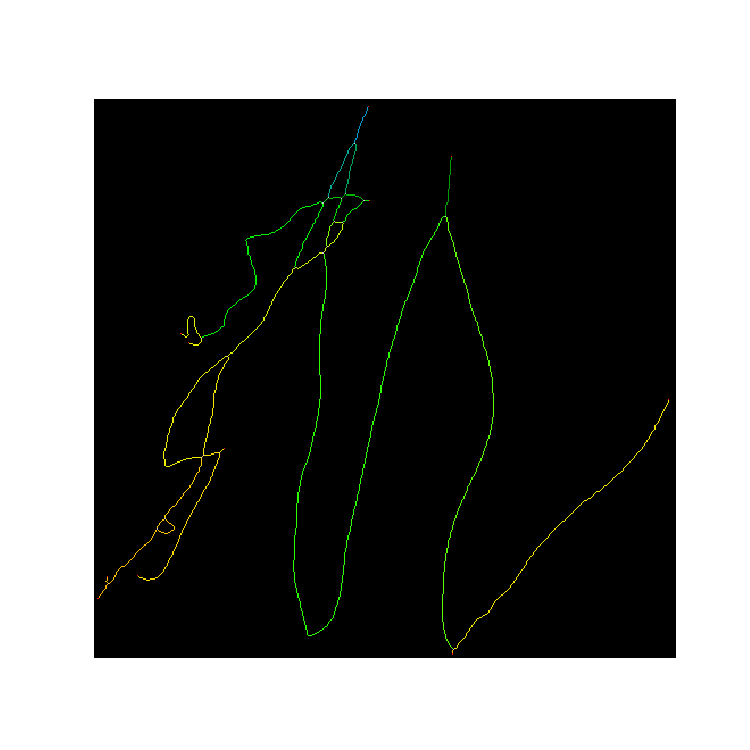

In [275]:
fig, m_axs = plt.subplots(1,1, figsize=(5,5), dpi=150)
im = m_axs.imshow(img_edge_labelled_copy, cmap='nipy_spectral', interpolation='none',norm=mpl.colors.PowerNorm(gamma=0.25))
m_axs.axis('off')
plt.show()

In [360]:
img_edge_labelled_copy = np.copy(img_cleaned_label)
for i,(x,y) in enumerate(all_nodes):
    rr,cc = draw.disk((x,y),1)
    img_edge_labelled_copy[rr, cc] = i+1

<IPython.core.display.Javascript object>


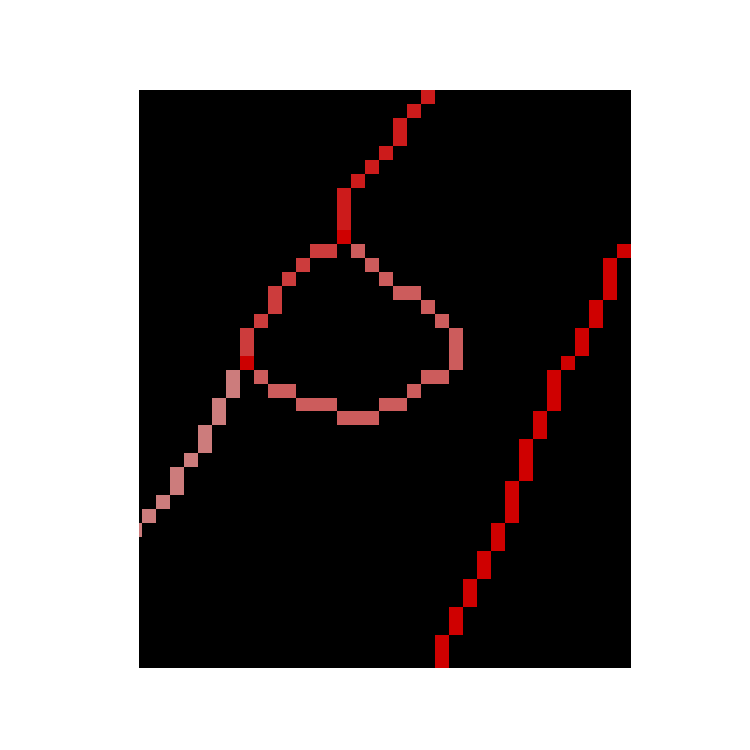

In [365]:
fig, m_axs = plt.subplots(1,1, figsize=(5,5), dpi=150)
im = m_axs.imshow(img_edge_labelled_copy, cmap='nipy_spectral', interpolation='none',norm=mpl.colors.PowerNorm(gamma=0.25))
m_axs.axis('off')
plt.show()

In [ ]:
# keep one branch - longest.
# Test removed branches which is longest and keep
# add removed branch labels to list and check
# for each intersection node, what are the surrounding branches labels. Keep whichever 2 has highest sum

# local curvature

In [141]:
node_edges = get_edges(img_cleaned_label, all_nodes) #edges at each node
node_edges

[array([1], dtype=int64),
 array([4], dtype=int64),
 array([10], dtype=int64),
 array([22], dtype=int64),
 array([23], dtype=int64),
 array([26], dtype=int64),
 array([27], dtype=int64),
 array([29], dtype=int64),
 array([35], dtype=int64),
 array([36], dtype=int64),
 array([37], dtype=int64),
 array([3, 1, 2], dtype=int64),
 array([6, 3, 5], dtype=int64),
 array([7, 2, 8], dtype=int64),
 array([5, 9, 7], dtype=int64),
 array([10,  6, 12], dtype=int64),
 array([ 8, 13, 11], dtype=int64),
 array([15,  4, 14], dtype=int64),
 array([17,  9, 16], dtype=int64),
 array([12, 18, 17], dtype=int64),
 array([18, 16, 19], dtype=int64),
 array([19, 14, 20], dtype=int64),
 array([20, 13, 21], dtype=int64),
 array([11, 23, 22], dtype=int64),
 array([21, 25, 24], dtype=int64),
 array([27, 29, 28], dtype=int64),
 array([28, 25, 30], dtype=int64),
 array([30, 31, 24], dtype=int64),
 array([33, 31, 32], dtype=int64),
 array([33, 32, 34], dtype=int64),
 array([34, 35, 36], dtype=int64),
 array([26, 15, 3

In [359]:
len(node_edges)

32

In [142]:
edge_int = list(range(1,max(map(max, node_edges))+1))
print(edge_int)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [426]:
# need to find what nodes are connected by edges. Edge range 1-max(edges)+1 = 31
# for each edge, check each node
# just need node index
#### Get which what nodes are connected by edges
edges = []
for edge_id in edge_int:
    connection = []
    for node_id in range(len(node_edges)): #j,k in enumerate try
        #print([k for k, e in enumerate(node_edges[j]) if e == i])
        e = np.where(node_edges[node_id] == edge_id)[0]
        if e.size > 0:
            #print(e, edge_id, node_id+1) #position around node, edge id, connecting to node j
            connection.append(node_id+1)
    edges.append(tuple(connection))
#edge ID is index (+1), nodes connected by edge. Need only 2. See above            

In [427]:
edges

[(1, 12),
 (12, 14),
 (12, 13),
 (2, 18),
 (13, 15),
 (13, 16),
 (14, 15),
 (14, 17),
 (15, 19),
 (3, 16),
 (17, 24),
 (16, 20),
 (17, 23),
 (18, 22),
 (18, 32),
 (19, 21),
 (19, 20),
 (20, 21),
 (21, 22),
 (22, 23),
 (23, 25),
 (4, 24),
 (5, 24),
 (25, 28),
 (25, 27),
 (6, 32),
 (7, 26),
 (26, 27),
 (8, 26),
 (27, 28),
 (28, 29),
 (29, 30),
 (29, 30),
 (30, 31),
 (9, 31),
 (10, 31),
 (11, 32)]

In [428]:
def get_edge_length(label_img, edge_list):
    edge_length = []
    for edge in edge_list:
        length = np.sum(np.where(label_img == edge, 1, 0))
        edge_length.append(length)
    return edge_length

In [429]:
edge_lengths = get_edge_length(img_cleaned_label, edge_int)

In [430]:
edge_data = []
for i,(j,k) in enumerate(edges):
    edge_data.append(((j,k), {'weight':edge_lengths[i]}))

In [467]:
import networkx as nx
from IPython.display import Image

In [468]:
# create graph
# G = nx.Graph()
G = nx.MultiGraph()
edge_number = G.add_edges_from(edges)
#G.add_edges_from(edge_data)

In [469]:
for i,(j,k) in enumerate(edges):
    G[j][k][edge_number[i]]['edge_id'] = i+1
    G[j][k][edge_number[i]]['weight'] = edge_lengths[i]

In [470]:
nx.is_weighted(G)

True

# VISUALIZATION

<IPython.core.display.Javascript object>


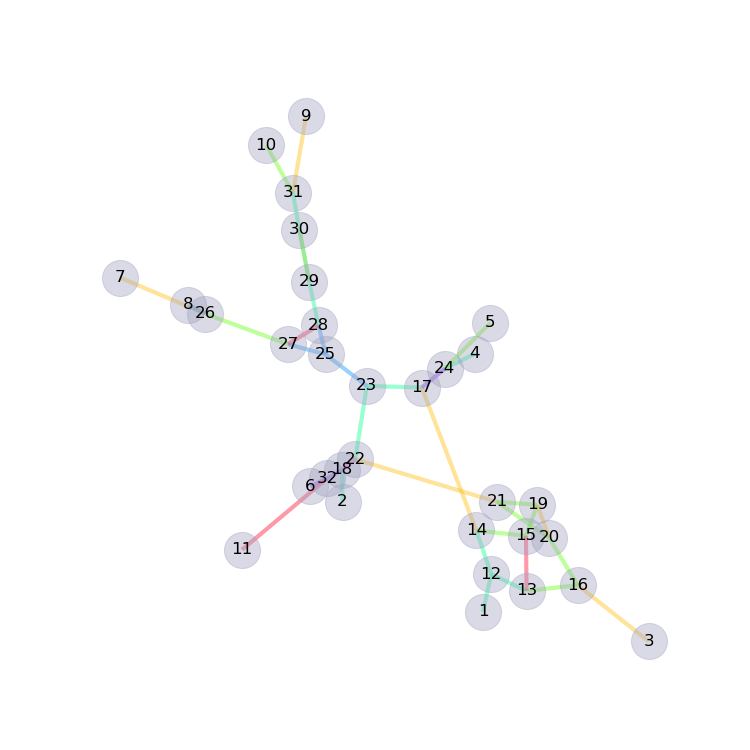

In [471]:
edge_labels = nx.get_edge_attributes(G,'edge_id')
Gedges,Gweights = zip(*nx.get_edge_attributes(G,'weight').items())
weights_norm = list(map(int,np.log(((Gweights - min(Gweights)) / (max(Gweights) - min(Gweights))) * max(Gweights)+1)))
pos=nx.spring_layout(G)
#pos = nx.random_layout(G, seed=42)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.planar_layout(G)
#pos = nx.spectral_layout(G)
color_range = range(len(edges))
fig, m_axs = plt.subplots(1,1, figsize=(5,5), dpi=150)
nx.draw_networkx_nodes(G,pos,node_color='#a3a3c2',alpha=0.4)
nx.draw_networkx_edges(G,pos,alpha=0.4,node_size=0,width=2, edge_color=weights_norm, edge_cmap=plt.cm.gist_rainbow)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
# nx.draw(G,pos,edge_color=color_range,edge_cmap=plt.cm.nipy_spectral, with_labels=False)
# nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
m_axs.axis('off')
plt.show()

In [472]:
weights_norm = list((Gweights - min(Gweights)) / (max(Gweights) - min(Gweights)))

In [497]:
cmap = plt.cm.get_cmap('gist_rainbow')
edge_colors = list(map(cmap, weights_norm)) #(1.0, 0.0, 0.0972549019607843, 1.0)
hex_colors = []
for color in edge_colors:
    rgb = color[:-1] # will return rgba, we take only first 3 so we get rgb
    hex_colors.append(mpl.colors.rgb2hex(rgb))

In [498]:
for i,edge in enumerate(G.edges(data=True)): 
    edge[2]['label'] = edge[2]['weight']

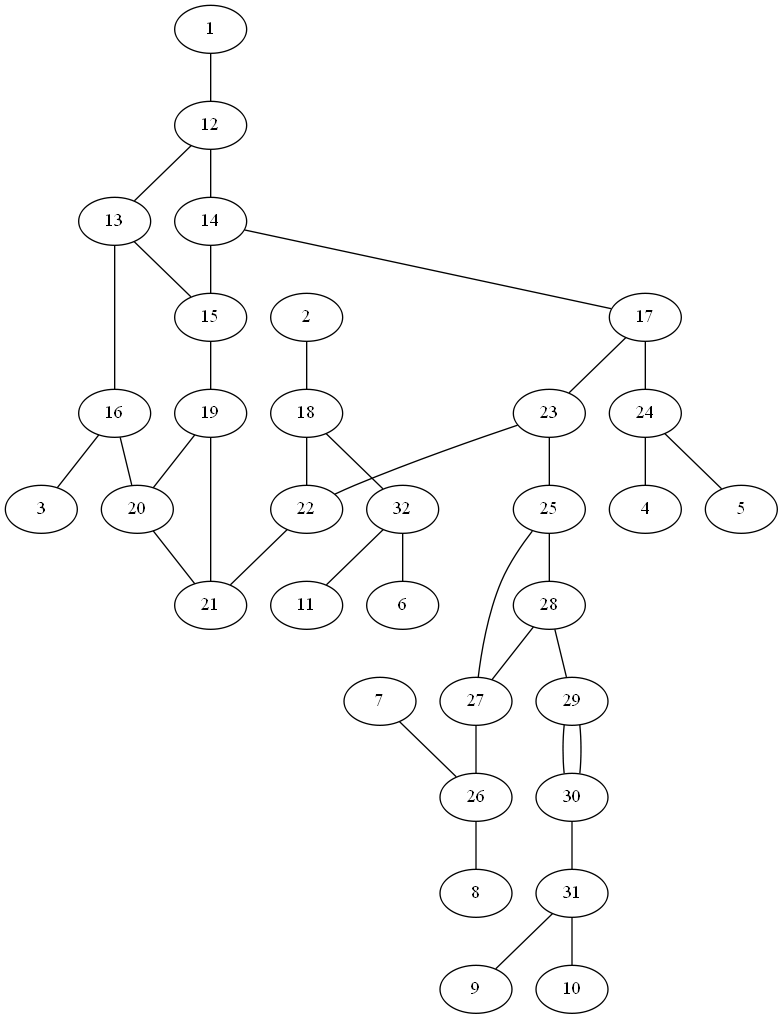

In [474]:
node_label = nx.get_node_attributes(G,'id')
pos = nx.spring_layout(G)
p=nx.drawing.nx_pydot.to_pydot(G)
# for i, edge in enumerate(p.get_edges()):
#     edge.set_label("e%d" % i)
p.write_png('multi.png')
Image(filename='multi.png')

In [ ]:
from string import ascii_lowercase   
try:
    assert len(nodes) < len(ascii_lowercase)
    node_names = [ascii_lowercase[i] for i in range(len(nodes))]
except AssertionError:
    print('Error')
res = dict(zip(node_names, node_edges))
node_edge_tuples = list(map(tuple, node_edges)) # what edges nodes are connected to